# 5.8. Writing massively parallel code for NVIDIA graphics cards (GPUs) with CUDA

In [1]:
import math
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
len(cuda.gpus)

1

In [3]:
cuda.gpus[0].name

b'GeForce GTX 980M'

In [4]:
@cuda.jit
def mandelbrot_numba(m, iterations):
    # Matrix index.
    i, j = cuda.grid(2)
    size = m.shape[0]
    # Skip threads outside the matrix.
    if i >= size or j >= size:
        return
    # Run the simulation.
    c = (-2 + 3. / size * j +
         1j * (1.5 - 3. / size * i))
    z = 0
    for n in range(iterations):
        if abs(z) <= 10:
            z = z * z + c
            m[i, j] = n
        else:
            break

In [5]:
size = 400
iterations = 100

In [6]:
m = np.zeros((size, size))

In [7]:
# 16x16 threads per block.
bs = 16
# Number of blocks in the grid.
bpg = math.ceil(size / bs)
# We prepare the GPU function.
f = mandelbrot_numba[(bpg, bpg), (bs, bs)]

In [8]:
f(m, iterations)

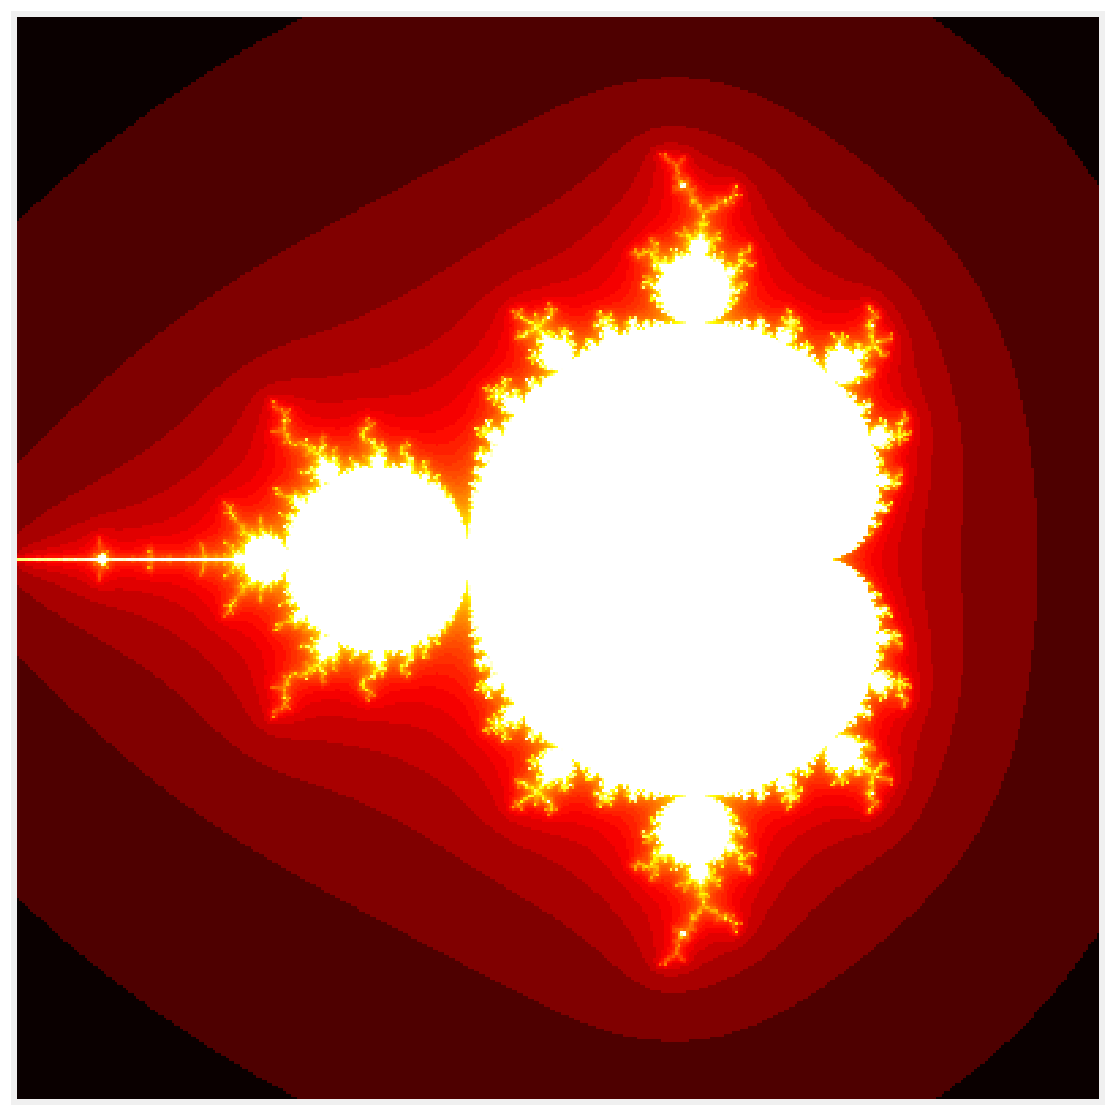

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()

In [10]:
%timeit -n10 -r100 f(m, iterations)

2.99 ms ± 173 µs per loop (mean ± std. dev. of 100 runs,
    10 loops each)


In [11]:
%timeit -n10 -r100 cuda.to_device(m)

481 µs ± 106 µs per loop (mean ± std. dev. of 100 runs,
    10 loops each)


In [12]:
%%timeit -n10 -r100 m_gpu = cuda.to_device(m)
f(m_gpu, iterations)

101 µs ± 11.8 µs per loop (mean ± std. dev. of 100 runs,
    10 loops each)


In [13]:
m_gpu = cuda.to_device(m)

In [14]:
%timeit -n10 -r100 m_gpu.copy_to_host()

238 µs ± 67.8 µs per loop (mean ± std. dev. of 100 runs,
    10 loops each)


```
# Thread id in a 1D block
tx = cuda.threadIdx.x
# Block id in a 1D grid
ty = cuda.blockIdx.x
# Block width, i.e. number of threads per block
bw = cuda.blockDim.x
# Compute flattened index inside the array
pos = tx + ty * bw
if pos < an_array.size:  # Check array boundaries
    # One can access `an_array[pos]`
```